## Anomaly Detection
Here, we implement an anomaly detection algorithm to detect anomalous behavior in server computers. The features measure the throughput (mb/s) and latency (ms) of response of each server. While your servers were operating, we collected $m = 307$ examples of how they were behaving, and thus have an unlabeled dataset $\{x^{(1)}, \dots, x^{(m)}\}$. We suspect that the vast majority of these examples are "normal" (non-anomalous) examples of the servers operating normally, but there might also be some examples of servers acting anomalously within this dataset.

We use a Gaussian model to detect anomalous examples in your dataset. We first start on a 2D dataset that will allow us to visualize what the algorithm is doing. On that dataset, we fit a Gaussian distribution and then find values that have very low probability and hence can be considered anomalies. After that, we apply the anomaly detection algorithm to a larger dataset with many dimensions. 

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from utils.util8 import visualizeFit
plt.style.available
plt.style.use('seaborn-v0_8')

In [20]:
data1 = scipy.io.loadmat('./data/ex8data1.mat')
data1.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [21]:
X1, Xval1, yval1 = data1['X'], data1['Xval'], data1['yval']
yval1 = yval1.flatten()
X1.shape, Xval1.shape, yval1.shape

((307, 2), (307, 2), (307,))

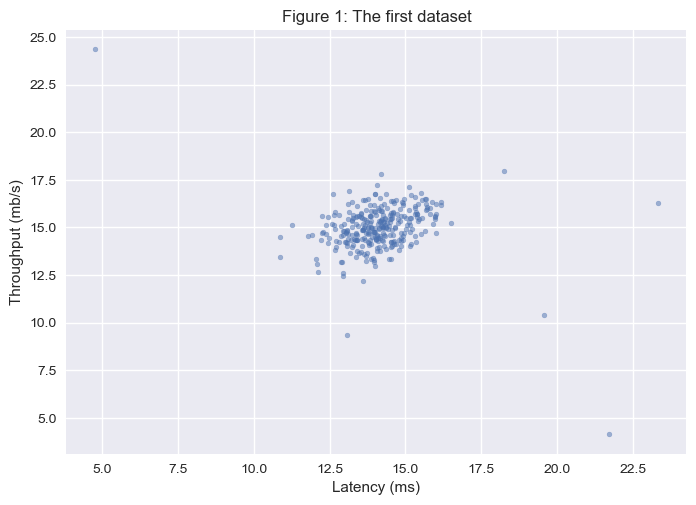

In [22]:
plt.scatter(X1[:, 0], X1[:, 1], marker='.', alpha=0.5)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.title("Figure 1: The first dataset")
plt.show()

## Gaussian Distribution

To perform anomaly detection, we first need to fit a model to the data’s distribution.

Given a training set $ \{x^{(1)}, \dots ,x^{(m)} \} $ (where $ x^{(i)} \in \mathbb{R}^n $), you want to estimate the Gaussian distribution for each of the features $x_i$. For each feature $i = 1, \dots ,n$, you need to find parameters $ \mu_i $ and $ \sigma_i^2 $ that fit the data in the $i$-th dimension $ \{x^{(1)}_i, \dots ,x^{(m)}_i \} $ (the $i$-th dimension of each example).

The Gaussian distribution is given by:

$$
p(x; \mu, \sigma^2) = \frac{1}{\sqrt{2\pi \sigma^2}} e^{-\frac{(x - \mu)^2}{2\sigma^2}},
$$

where $ \mu $ is the mean and $ \sigma^2 $ controls the variance.

## Estimating Parameters for a Gaussian

We can estimate the parameters, $(\mu_i, \sigma_i^2)$, of the $i$-th feature by using the following equations. 

To estimate the mean, you will use:

$$
\mu_i = \frac{1}{m} \sum_{j=1}^{m} x_i^{(j)},
$$

and for the variance, you will use:

$$
\sigma_i^2 = \frac{1}{m} \sum_{j=1}^{m} \left( x_i^{(j)} - \mu_i \right)^2.
$$

The function `estimateGaussian` takes as input the data matrix `X` and outputs an $n$-dimension vector `mu` that holds the mean of all the $n$ features, and another $n$-dimension vector `sigma2` that holds the variances of all the features.

We can implement this using a for-loop over every feature and every training example or by using a vectorized implementation which will be more efficient.

Finally, we visualize the contours of the fitted Gaussian distribution. We get `Figure 2`, and we observe that most of the examples are in the region with the highest probability, while the anomalous examples are in the regions with lower probabilities.

In [23]:
def estimateGaussian_loop(X):
    m, n = X.shape
    mu = []
    sigma2 = []
    for i in range(n):
        mu_temp = 0
        for j in range(m):
            mu_temp += X[j, i]
        mu_temp = mu_temp / m
        mu.append(mu_temp)
    for i in range(n):
        sigma2_temp = 0
        for j in range(m):
            sigma2_temp += ( X[j, i] - mu[i])**2
        sigma2_temp = sigma2_temp / m
        sigma2.append(sigma2_temp)
    return np.array(mu), np.array(sigma2)

estimateGaussian_loop(X1)

(array([14.11222578, 14.99771051]), array([1.83263141, 1.70974533]))

In [24]:
def estimateGaussian(X):
    mu = np.mean(X, axis=0)
    sigma2 = np.var(X, axis=0)
    return mu, sigma2

estimateGaussian(X1)

(array([14.11222578, 14.99771051]), array([1.83263141, 1.70974533]))

In [25]:
mu, sigma2 = estimateGaussian(X1)

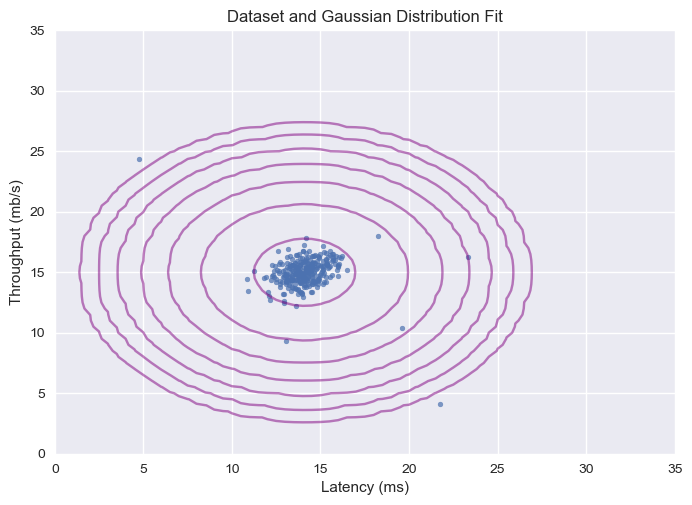

In [26]:
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.title('Dataset and Gaussian Distribution Fit')
visualizeFit(X1, mu, sigma2);

## Selecting the threshold $ \epsilon $

Now that we have estimated the Gaussian parameters, we can investigate which examples have a very high probability given this distribution and which examples have a very low probability. The low probability examples are more likely to be the anomalies in our dataset. One way to determine which examples are anomalies is to select a threshold based on a cross validation set. We implement an algorithm to select the threshold $ \epsilon $ using the $F_1$ score on a cross validation set.

The function `selectThreshold` returns  $ \epsilon $ and $F_1$. For this, we use a cross validation set $\{(x_{\text{cv}}^{(1)},y_{\text{cv}}^{(1)}),\ldots,(x_{\text{cv}}^{(m_{\text{cv}})}, y_{\text{cv}}^{(m_{\text{cv}})})\}$, where the label $ y = 1 $ corresponds to an anomalous example, and $ y = 0 $ corresponds to a normal example. For each cross validation example, we compute $ p(x_{\text{cv}}^{(i)}) $. The vector of all of these probabilities $ p(x_{\text{cv}}^{(1)}), \dots, p(x_{\text{cv}}^{(m_{\text{cv}})}) $ is passed to `selectThreshold` in the vector `pval`. The corresponding labels $ y_{\text{cv}}^{(1)}, \dots, y_{\text{cv}}^{(m_{\text{cv}})} $ are passed to the same function in the vector `yval`.

The function `selectThreshold` returns two values: the first is the selected threshold $ \epsilon $. If an example $ x $ has a low probability $ p(x) < \epsilon $, then it is considered to be an anomaly. The function should also return the $F_1$ score, which tells how well we’re doing on finding the ground truth anomalies given a certain threshold. For many different values of $ \epsilon $, we compute the resulting $F_1$ score by computing how many examples the current threshold classifies correctly and incorrectly.

The $F_1$ score is computed using precision (prec) and recall (rec):

$$
F_1 = \frac{2 \cdot \text{prec} \cdot \text{rec}}{\text{prec} + \text{rec}}
$$

You compute precision and recall by:

$$
\text{prec} = \frac{\text{tp}}{\text{tp} + \text{fp}}
$$

$$
\text{rec} = \frac{\text{tp}}{\text{tp} + \text{fn}}
$$

Where:
- $ \text{tp} $ is the number of **true positives**: the ground truth label says it's an anomaly, and our algorithm correctly classified it as an anomaly.
- $ \text{fp} $ is the number of **false positives**: the ground truth label says it's not an anomaly, but our algorithm incorrectly classified it as an anomaly.
- $ \text{fn} $ is the number of **false negatives**: the ground truth label says it's an anomaly, but our algorithm incorrectly classified it as not being anomalous.

In the provided code `selectThreshold.m`, there is already a loop that will try many different values of $ \epsilon $ and select the best $ \epsilon $ based on the F1 score. You should now complete the code in `selectThreshold.m`. You can implement the computation of the F1 score using a for-loop over all the cross validation examples (to compute the values $ \text{tp} $, $ \text{fp} $, and $ \text{fn} $). You should see a value for $ \epsilon $ of about $ 8.99 \times 10^{-5} $.

Once you have completed the code in `selectThreshold.m`, the next step in `ex8.m` will run your anomaly detection code and circle the anomalies in the plot (Figure 3).

In [27]:
def multivariateGaussian(X, mu, sigma_squared):
    """Computes the probability density function of the multivariate Gaussian distribution"""
    prefactor = 1 / np.sqrt(2 * np.pi * sigma_squared)
    exponent = -((X - mu)**2) / (2 * sigma_squared)
    
    pdf_value = prefactor * np.exp(exponent)
    if len(X.shape)> 1: 
        return np.prod(pdf_value, axis=1)
    else: 
        return np.prod(pdf_value)

multivariateGaussian(X1[0], mu, sigma2)

0.06470828501170225

In [28]:
def selectThreshold(y_val, p_val): 
    """
    Finds the best threshold to use for selecting outliers based on:
    the results from a validation set (p_val) and the ground truth (y_val)
    """ 

    best_epsilon = 0
    best_F1 = 0
    F1 = 0
    
    step_size = (max(p_val) - min(p_val)) / 1000
    
    for epsilon in np.arange(min(p_val), max(p_val), step_size):            
        # Convert probabilities to predictions based on epsilon
        predictions = (p_val < epsilon).astype(int)
        
        # Calculate true positives, false positives, and false negatives
        tp = np.sum((predictions == 1) & (y_val == 1))
        fp = np.sum((predictions == 1) & (y_val == 0))
        fn = np.sum((predictions == 0) & (y_val == 1))
        
        # Calculate precision and recall
        precision = tp / (tp + fp) if (tp + fp) != 0 else 0
        recall = tp / (tp + fn) if (tp + fn) != 0 else 0
        
        # Calculate F1 score
        F1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
        
        if F1 > best_F1:
            best_F1 = F1
            best_epsilon = epsilon
        
    return best_epsilon, best_F1

In [29]:
pval1 = multivariateGaussian(Xval1, mu, sigma2)
epsilon, F1 = selectThreshold(yval1, pval1)
epsilon, F1

(8.990852779269492e-05, 0.8750000000000001)

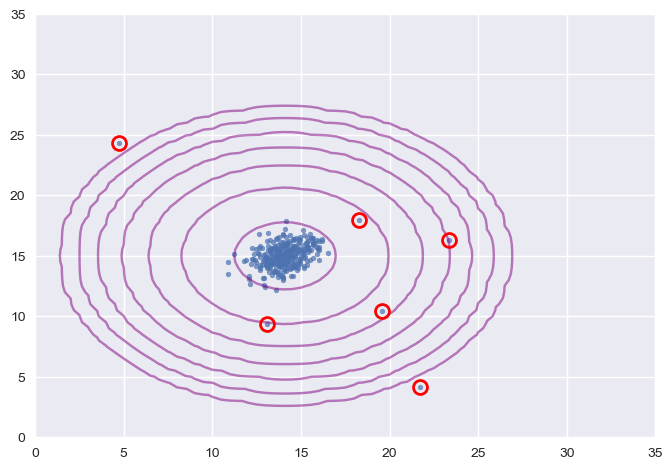

In [30]:
# Find the outliers in the training set 
mu, sigma2 = estimateGaussian(X1)
p = multivariateGaussian(X1, mu, sigma2)
outliers = p < epsilon

# Visualize the fit
visualizeFit(X1, mu, sigma2)

# Draw a red circle around those outliers
plt.plot(X1[outliers, 0], X1[outliers, 1], 'ro', markersize= 10, markerfacecolor='none', markeredgewidth=2)

## High Dimensional Dataset

Here run the anomaly detection algorithm you implemented on a more realistic and much harder dataset. 
In this dataset, each example is described by 11 features, capturing many more properties of your compute servers.

The script will use your code to estimate the Gaussian parameters (µₑ and σ²ₑ), evaluate the probabilities for both the training data `X` (from which you estimated the Gaussian parameters), and do so for the cross-validation set `Xval`. Finally, it will use `selectThreshold` to find the best threshold ε. 

You should see a value of epsilon around **1.38e-18**, and **117 anomalies** found.

In [31]:
data2 = scipy.io.loadmat('./data/ex8data2.mat')
X2, Xval2, yval2 = data2['X'], data2['Xval'], data2['yval']
yval2 = yval2.flatten()
X2.shape, Xval2.shape, yval2.shape

((1000, 11), (100, 11), (100,))

In [32]:
mu2, var2 = estimateGaussian(X2)
pval2 = multivariateGaussian(Xval2, mu2, var2)
epsilon, F1 = selectThreshold(yval2, pval2)
epsilon, F1

(1.377228890761357e-18, 0.6153846153846154)

In [33]:
p = multivariateGaussian(X2, mu2, var2)
outliers = p < epsilon
np.sum(outliers)

117